# BioImageSuiteLite: Comprehensive Analysis Guide

## Table of Contents
1. [Introduction](#introduction)
2. [Installation and Setup](#installation)
3. [Loading and Visualizing Data](#loading-data)
4. [ROI Definition and Management](#roi-management)
5. [Parameter Optimization](#parameter-optimization)
6. [Running Analysis](#running-analysis)
7. [Understanding Results](#understanding-results)
8. [Exporting and Post-Processing](#exporting)
9. [Troubleshooting](#troubleshooting)
10. [Advanced Tips](#advanced-tips)

---

## 1. Introduction <a id="introduction"></a>

BioImageSuiteLite is designed for detecting and analyzing transient cellular events in time-lapse microscopy data. This notebook provides a comprehensive guide to using all features of the software.

### What types of events can be detected?
- **Calcium transients** in neurons or other excitable cells
- **Vesicle fusion events** at the cell membrane
- **Fluorescence fluctuations** from reporter proteins
- Any **transient intensity changes** in time-lapse imaging

### Detection Methods Available:
1. **Threshold-based detection**: Finds events when intensity crosses a threshold
2. **Difference of Gaussians (DoG)**: Detects blob-like features and intensity peaks
3. **Scisson-like analysis**: For step-like changes (currently in development)


## 2. Installation and Setup <a id="installation"></a>

Before starting, ensure you have BioImageSuiteLite installed. If you're running this notebook from the repository, we'll set up the environment.


In [1]:
# Setup the environment
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Add parent directory to path if running from repo
if os.path.exists('../BioImageSuiteLite'):
    sys.path.insert(0, os.path.abspath('..'))
    print("✓ Added parent directory to Python path")
else:
    print("✓ Using installed BioImageSuiteLite package")

# Import BioImageSuiteLite modules
try:
    from BioImageSuiteLite import gui_manager, io_operations, analysis_processor, roi_handler
    print("✓ Successfully imported BioImageSuiteLite modules")
except ImportError as e:
    print("✗ Error importing modules:", e)
    print("Please ensure BioImageSuiteLite is properly installed")

# Set up matplotlib for inline plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
print("✓ Matplotlib configured for inline plotting")


✓ Added parent directory to Python path
2025-06-16 11:23:08 [INFO] BioImageSuiteLite: Logging initialized.
✓ Successfully imported BioImageSuiteLite modules
✓ Matplotlib configured for inline plotting


## 3. Loading and Visualizing Data <a id="loading-data"></a>

BioImageSuiteLite supports both `.avi` video files and multi-page `.tif`/`.tiff` files. The software automatically converts color videos to greyscale for analysis.

### Step 3.1: Launch the GUI

First, let's launch the BioImageSuiteLite interface. A new window will open with the analysis tools.

**What to expect:**
- A Napari viewer window will open showing your data
- Control panels on the right side for analysis parameters
- Results table and log at the bottom

**Action required:** Run the cell below and wait for the GUI to open.


In [2]:
# Launch the BioImageSuiteLite GUI
import warnings
import logging

# Suppress the FutureWarning about qt_viewer
warnings.filterwarnings('ignore', category=FutureWarning, module='BioImageSuiteLite.gui_manager')

# Configure logging to avoid showing full paths
logging.getLogger('BioImageSuiteLite').handlers = []

print("Launching BioImageSuiteLite...")
print("=" * 50)
print("IMPORTANT: A new window will open")
print("Do NOT close this notebook while using the GUI")
print("=" * 50)

# Start the application
gui_manager.main()

# Note: The cell will continue running while the GUI is open
# This is normal - the GUI runs in its own event loop


Launching BioImageSuiteLite...
IMPORTANT: A new window will open
Do NOT close this notebook while using the GUI
2025-06-16 11:23:08 [INFO] BioImageSuiteLite: Logging initialized.
INFO: Pixel size set to 0.160 µm/pixel.


### Step 3.2: Load Your Video File

Now that the GUI is open, let's load your data:

1. **Click "Load File"** button in the File Operations section
2. **Navigate to your video file** (.avi or .tif/.tiff) and select it
3. The video will be loaded and automatically converted to greyscale if needed

**What happens during loading:**
- The software reads all frames from the video
- For AVI files: Extracts frames and metadata (FPS, dimensions)
- For TIFF files: Reads all pages and attempts to extract FPS from metadata
- Converts RGB to greyscale using standard luminance weights
- Displays the first frame in the viewer

**Tips:**
- Supported formats: `.avi`, `.tif`, and `.tiff` files
- Large files may take a moment to load
- The status will show frame count, FPS, and dimensions
- For TIFF files without FPS metadata, a default of 30 FPS is used

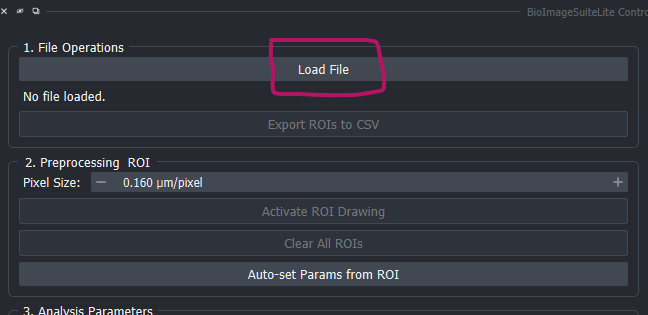


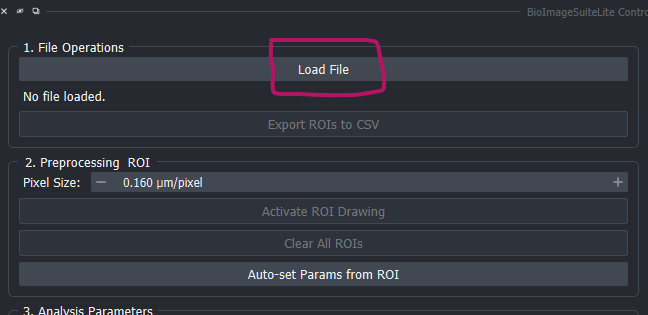

In [3]:
import base64
from IPython.display import display, Markdown

# Path to the local image file from the root of your project
image_path = "images/load_file_button.png"

# Read the image file in binary mode
with open(image_path, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode()

# Create the full markdown string for the embedded image
# This is the string you can copy and paste into a markdown cell
markdown_string = f"![Load File Button Location](data:image/png;base64,{encoded_string})"
display(Markdown(markdown_string))

**After loading, you should see:**
- Your video displayed in the main viewer
- Frame slider at the bottom to navigate through time
- File information displayed in the control panel


### Step 3.3: Set Pixel Size (Important!)

Before analysis, you must set the correct pixel size for your microscope:

1. **Locate "Pixel Size (µm/pixel)"** in the Preprocessing section
2. **Enter your microscope's pixel size** (default is 0.16 µm/pixel)
3. The value updates automatically when you change it

**Why this matters:**
- Event rates are normalized by area (events/second/µm²)
- Incorrect pixel size will give wrong absolute rates
- This value depends on your microscope objective and camera

**How to find your pixel size:**
- Check your microscope's specifications
- Calculate from known object dimensions
- Common values: 
  - 100x objective: 0.065-0.13 µm/pixel
  - 60x objective: 0.11-0.22 µm/pixel
  - 40x objective: 0.16-0.33 µm/pixel
  - 20x objective: 0.32-0.65 µm/pixel

![Pixel Size Setting](images/pixel_size_setting.png)


## 4. ROI Definition and Management <a id="roi-management"></a>

Regions of Interest (ROIs) define where to analyze events. You can draw multiple ROIs to compare different cells or regions.

### Step 4.1: Activate ROI Drawing Mode

1. **Click "Activate ROI Drawing"** button
2. The button text changes to "Finish ROI Drawing"
3. Your cursor becomes a drawing tool

### Step 4.2: Draw ROIs

1. **Click points around your cell/region** to create a polygon
2. **Double-click to close** the polygon
3. The ROI will appear with a red outline
4. **Repeat** for additional ROIs

**Best practices for ROI drawing:**
- Draw tightly around individual cells
- Avoid overlapping ROIs
- Include the entire cell body
- Exclude background regions
- For neurons: include soma and proximal dendrites

![ROI Drawing Example](images/roi_drawing.png)

### Step 4.3: Manage ROIs

**ROI Information displayed:**
- ROI ID number
- Area in pixels and µm²
- Automatically calculated after drawing

**ROI Management options:**
- **Clear All ROIs**: Remove all ROIs and start over
- **Select ROI**: Click on an ROI to select it
- Selected ROIs are used for parameter estimation

### Step 4.4: Finish ROI Drawing

When done drawing ROIs:
1. **Click "Finish ROI Drawing"** to exit drawing mode
2. The viewer returns to pan/zoom mode
3. You can now select and modify existing ROIs


## 5. Parameter Optimization <a id="parameter-optimization"></a>

Proper parameter selection is crucial for accurate event detection. BioImageSuiteLite offers both automatic and manual parameter optimization.

### Step 5.1: Understanding Detection Parameters

#### Threshold Detection Parameters:
- **Enable Threshold Detection**: Check to use this method
- **Threshold Value**: Intensity level that triggers an event
- **Use Otsu**: Automatically calculate optimal threshold

#### DoG (Difference of Gaussians) Parameters:
- **Enable DoG Detection**: Check to use this method
- **Sigma 1**: Smaller gaussian kernel (typically 1-5)
- **Sigma 2**: Larger gaussian kernel (typically 2-10)
- **Min Prominence**: Minimum peak height (0 = auto)

#### General Parameters:
- **Min Event Separation**: Minimum time between events (seconds)
  - Prevents double-counting of the same event
  - Typical values: 0.1-1.0 seconds

### Step 5.2: Automatic Parameter Estimation

BioImageSuiteLite can estimate optimal DoG parameters from your data:

1. **Select one or more ROIs** by clicking on them
2. **Click "Auto-set Params from ROI"**
3. Parameters will be calculated based on the intensity profile

**How it works:**
- Analyzes intensity fluctuations in selected ROIs
- If multiple ROIs selected: averages their traces for global parameters
- Estimates optimal sigma values based on event characteristics
- Sets prominence based on noise level

![Auto Parameter Setting](images/auto_params.png)


### Step 5.3: Manual Parameter Tuning Guide

If automatic estimation doesn't work well, here's how to manually optimize:

#### For Threshold Detection:
1. **Start with Otsu** (check "Use Otsu")
2. Run analysis and check results
3. If too many false positives: increase threshold
4. If missing events: decrease threshold

#### For DoG Detection:
1. **Sigma 1**: Set to approximate radius of your events (in pixels)
2. **Sigma 2**: Set to 1.5-2x Sigma 1
3. **Min Prominence**: Start at 0 (auto), increase if too many false detections

#### Parameter Tuning Strategy:
1. **Enable only one method at a time** initially
2. **Test on a single ROI** first
3. **Adjust parameters** based on results
4. **Apply to all ROIs** once optimized

**Common parameter sets by application:**
- **Calcium transients**: Sigma1=2-4, Sigma2=4-8, Prominence=10-50
- **Vesicle fusion**: Sigma1=1-2, Sigma2=2-4, Prominence=5-20
- **Large events**: Sigma1=5-10, Sigma2=10-20, Prominence=20-100

### Step 5.4: Understanding Event Types in Results

When both detection methods are enabled, you may see different event types:
- **"threshold"**: Events detected by intensity threshold crossing
- **"dog"**: Events detected by Difference of Gaussians peaks

The Min Event Separation parameter helps merge events detected by both methods if they occur close in time.


## 6. Running Analysis <a id="running-analysis"></a>

Once parameters are set, you're ready to analyze your data.

### Step 6.1: Run Full Analysis

1. **Ensure at least one detection method is enabled**
2. **Click "Run Full Analysis"** button
3. **Wait for processing** (progress shown in log)

**What happens during analysis:**
1. For each ROI:
   - Extract mean intensity trace
   - Apply enabled detection methods
   - Filter duplicate events
   - Calculate normalized rates
2. Results appear in the table
3. Summary statistics are calculated

![Run Analysis Button](images/run_analysis.png)

### Step 6.2: Monitor Progress

Watch the log window for:
- Processing status for each ROI
- Number of events detected
- Any warnings or errors
- Completion message

**Typical processing time:**
- Small dataset (100 frames): < 1 second
- Medium dataset (1000 frames): 2-5 seconds
- Large dataset (10000 frames): 10-30 seconds

### Step 6.3: Analysis Complete

When analysis finishes:
- Results table populates with all detected events
- Summary statistics are calculated for each ROI
- "Show Summary Plot" and "Export Results to CSV" buttons become enabled


## 7. Understanding Results <a id="understanding-results"></a>

### Step 7.1: Results Table

The results table shows detailed information for each detected event:

| Column | Description |
|--------|-------------|
| **ROI ID** | Which ROI the event occurred in |
| **Type** | Detection method (threshold, dog, scisson) |
| **Start (s)** | When the event began |
| **End (s)** | When the event ended |
| **Duration (s)** | How long the event lasted |
| **Events/s/µm²** | Normalized event rate |
| **Details** | Method-specific parameters |

### Step 7.2: Interpreting Event Rates

**Events/s/µm²** is the key metric:
- Normalized by ROI area and observation time
- Allows comparison between different sized ROIs
- Standard unit for reporting in publications

**Example interpretation:**
- Rate = 5.250e-02 events/s/µm²
- Means ~0.0525 events per second per µm²
- Or ~3.15 events per minute per µm²
- Or ~52.5 events per 1000 seconds per µm²

### Step 7.3: Summary Plot

Click **"Show Summary Plot"** to visualize:
- Event rates for each ROI
- Error bars showing standard error
- Comparison across all analyzed ROIs

![Summary Plot Example](images/summary_plot.png)


## 8. Exporting and Post-Processing <a id="exporting"></a>

### Step 8.1: Export Results to CSV

1. **Click "Export Results to CSV"**
2. Choose save location
3. File will contain:
   - Header with analysis timestamp
   - All event details
   - Can be opened in Excel/spreadsheet software

**CSV Format:**
```
Analysis Run At: 2025-01-15 11:53:51
ROI ID,Type,Start (s),End (s),Duration (s),Events/s/µm²,Details
1,threshold,10.5,11.2,0.7,5.250e-02,threshold_value:128
1,dog,15.3,15.8,0.5,5.250e-02,prominence:25.3
...
```

### Step 8.2: Working with Exported Data

The CSV file can be used for:
- Statistical analysis in R or Python
- Creating publication-quality figures
- Comparing results across experiments
- Archiving analysis results


Events by Detection Type:
Type
threshold    5
dog          4
Name: count, dtype: int64

Mean Duration by Type:
Type
dog          0.675
threshold    1.060
Name: Duration (s), dtype: float64


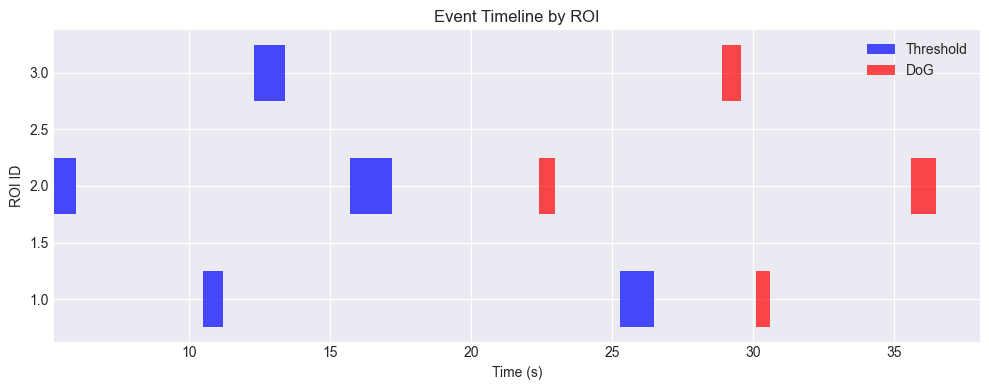

In [4]:
# Example: Post-processing exported CSV data
# This code demonstrates how to load and analyze your exported results

import pandas as pd
import matplotlib.pyplot as plt

# Example of loading exported CSV (replace with your file path)
# df = pd.read_csv('your_results.csv', skiprows=1)

# Create sample data for demonstration
sample_data = {
    'ROI ID': [1, 1, 1, 2, 2, 2, 2, 3, 3],
    'Type': ['threshold', 'threshold', 'dog', 'threshold', 'threshold', 'dog', 'dog', 'threshold', 'dog'],
    'Start (s)': [10.5, 25.3, 30.1, 5.2, 15.7, 22.4, 35.6, 12.3, 28.9],
    'Duration (s)': [0.7, 1.2, 0.5, 0.8, 1.5, 0.6, 0.9, 1.1, 0.7],
    'Events/s/µm²': [5.2e-03, 5.2e-03, 5.2e-03, 3.8e-03, 3.8e-03, 3.8e-03, 3.8e-03, 6.1e-03, 6.1e-03]
}

df = pd.DataFrame(sample_data)

# Analyze by detection type
print("Events by Detection Type:")
print(df['Type'].value_counts())
print("\nMean Duration by Type:")
print(df.groupby('Type')['Duration (s)'].mean())

# Plot event timeline
fig, ax = plt.subplots(figsize=(10, 4))

# Create handles for legend
from matplotlib.patches import Rectangle
threshold_patch = Rectangle((0, 0), 1, 1, fc='blue', alpha=0.7)
dog_patch = Rectangle((0, 0), 1, 1, fc='red', alpha=0.7)

for roi_id in df['ROI ID'].unique():
    roi_data = df[df['ROI ID'] == roi_id]
    y_pos = roi_id
    for _, event in roi_data.iterrows():
        color = 'blue' if event['Type'] == 'threshold' else 'red'
        ax.barh(y_pos, event['Duration (s)'], left=event['Start (s)'], 
                height=0.5, color=color, alpha=0.7)

ax.set_xlabel('Time (s)')
ax.set_ylabel('ROI ID')
ax.set_title('Event Timeline by ROI')
ax.legend([threshold_patch, dog_patch], ['Threshold', 'DoG'])
plt.tight_layout()
plt.show()


## 9. Troubleshooting <a id="troubleshooting"></a>

### Common Issues and Solutions

#### No events detected:
- **Check threshold**: May be too high
- **Verify ROI placement**: Ensure ROI covers active regions
- **Increase recording time**: Short recordings may miss events
- **Check data quality**: Low SNR may prevent detection

#### Too many false positives:
- **Increase Min Event Separation**: Filter rapid fluctuations
- **Increase threshold or prominence**: Be more selective
- **Check for motion artifacts**: Stabilize video if needed
- **Reduce detection sensitivity**: Use only one method

#### Different results between methods:
- **This is normal**: Methods detect different features
- **Threshold**: Detects intensity crossings
- **DoG**: Detects blob-like features
- **Use both**: For comprehensive analysis

#### Analysis crashes or hangs:
- **Check memory usage**: Large videos need more RAM
- **Reduce number of ROIs**: Process in batches
- **Update software**: Check for latest version
- **Check video format**: Ensure proper encoding

### Error Messages

**"FPS is zero or invalid"**
- Video metadata is corrupted
- For TIFF files: FPS defaults to 30 if not in metadata

**"ROI has zero area"**
- ROI is too small or improperly drawn
- Redraw ROI with larger area

**"Could not get intensity trace"**
- ROI may be outside image bounds
- Check ROI placement


## 10. Advanced Tips <a id="advanced-tips"></a>

### Batch Processing Multiple Files

While the GUI processes one file at a time, you can script batch processing:


In [5]:
# Example: Batch processing workflow (conceptual)
# Note: This requires programmatic access to the analysis functions

import os
from pathlib import Path

# Define batch processing function
def batch_process_videos(video_folder, output_folder, params):
    """
    Process multiple videos with the same parameters
    
    Args:
        video_folder: Path to folder containing video files
        output_folder: Where to save results
        params: Dictionary of analysis parameters
    """
    # Find all video files (both AVI and TIFF)
    video_files = list(Path(video_folder).glob("*.avi"))
    video_files.extend(list(Path(video_folder).glob("*.tif")))
    video_files.extend(list(Path(video_folder).glob("*.tiff")))
    
    results_summary = []
    
    for video_file in video_files:
        print(f"Processing: {video_file.name}")
        
        # Pseudocode for processing steps:
        # 1. Load video
        # frames, metadata = io_operations.load_file(str(video_file))
        
        # 2. Convert to greyscale
        # grey_stack = io_operations.convert_to_greyscale_stack(frames)
        
        # 3. Define ROIs (could load from file or use automatic detection)
        # roi_manager = roi_handler.ROIManager(grey_stack.shape)
        
        # 4. Run analysis with specified parameters
        # results = run_analysis(grey_stack, roi_manager, params)
        
        # 5. Save results
        # output_path = output_folder / f"{video_file.stem}_results.csv"
        # save_results(results, output_path)
        
        # results_summary.append({
        #     'file': video_file.name,
        #     'n_events': len(results),
        #     'mean_rate': calculate_mean_rate(results)
        # })
    
    return results_summary

# Example parameters for batch processing
batch_params = {
    'threshold_enabled': True,
    'threshold_value': 128,
    'use_otsu': False,
    'dog_enabled': True,
    'dog_sigma1': 2.0,
    'dog_sigma2': 4.0,
    'dog_prominence': 10.0,
    'min_event_separation': 0.5
}

# Example usage (uncomment to run):
# results = batch_process_videos("./videos", "./results", batch_params)


### Performance Optimization

For large datasets or many ROIs:

1. **Process in chunks**: Analyze subsets of ROIs
2. **Reduce frame rate**: Downsample if events are slow
3. **Use appropriate parameters**: Avoid overly sensitive detection
4. **Close other applications**: Free up system memory

### Integration with Other Tools

BioImageSuiteLite results can be used with:
- **ImageJ/Fiji**: Import TIFF stacks for further analysis
- **Python**: Load CSV results for custom analysis
- **R**: Statistical analysis of event rates
- **GraphPad Prism**: Publication-quality plots

### Publishing Your Results

When reporting BioImageSuiteLite results:
1. **Cite the software** (see README for citation)
2. **Report all parameters** used for analysis
3. **Include pixel size** and imaging conditions
4. **Show representative traces** and ROIs
5. **Report as**: events/s/µm² ± SEM

### Future Features

Planned enhancements include:
- Support for more file formats (.nd2, .czi)
- Automatic ROI detection
- Machine learning-based event detection
- Real-time analysis during acquisition
- 3D ROI support for volumetric data

---

## Conclusion

This guide covered the complete workflow for analyzing cellular events with BioImageSuiteLite. For specific questions or feature requests, please visit our [GitHub repository](https://github.com/raju1stnov/BioImageSuiteLite).

Happy analyzing!


In [6]:
import os
print(os.getcwd())

c:\kaushik\project_work\BioImageSuiteLite\examples
